### Question 1:

The K nearest neighbor algorithm has hyper-parameters in addition to K. Use the titanic dataset to simultaneously tune the values of more than one hyper-parameter. E.g. Value of K, weight, and metric. You can either do nested for loops for this or use the grid search OR random search function from scikit-learn. Recommendation is you submit code inside of a Jupyter notebook.

In [1]:
import numpy as np
import pandas as pd
import os
import sklearn
import joblib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,matthews_corrcoef,f1_score,classification_report,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
%matplotlib inline

#### Step1: Loading Data

In [2]:
# Loading data from given dataset by pandas
if os.path.isfile("./Data/Titanic_FullList.csv"):
    my_full_df = pd.read_csv("./Data/Titanic_FullList.csv")
else:
    my_df_1 = pd.read_csv("./Data/Titanic.csv")
    my_df_2 = pd.read_csv("./Data/Titanic_II.csv")
    my_full_df = my_df_1.append(my_df_2)
    my_full_df.to_csv("./Data/Titanic_FullList.csv", index = False)

In [3]:
# check the shape
my_df_1 = pd.read_csv("./Data/Titanic.csv")
my_df_2 = pd.read_csv("./Data/Titanic_II.csv")
my_full_df = pd.read_csv("./Data/Titanic_FullList.csv")
print(my_df_1.shape)
print(my_df_2.shape)
print(my_full_df.shape)

(891, 12)
(418, 12)
(1309, 12)


In [4]:
my_full_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
"""Check the columns"""
my_full_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]

In [7]:
'''Because the model has worse performance by using train_test_split(), using mydf_splitter() function from lecture instead'''
#select 70% as train, 15% as validation, 15% as test
#my_train_valid,my_test = train_test_split(my_full_df,test_size=0.15)

my_train_valid,my_test = mydf_splitter(my_full_df,1100)

my_train_valid.reset_index(inplace = True,drop=True)
my_test.reset_index(inplace = True,drop=True)

In [8]:
print(my_train_valid.shape,my_test.shape)

(1100, 12) (209, 12)


In [9]:
#train set has been selected randomly and covered all targets (Survived)
my_train_valid.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [10]:
#test set has been selected randomly and covered all targets (Survived)
my_test.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1101,1,3,"Delalic, Mr. Redjo",male,25.0,0,0,349250,7.8958,NaN,S
1,1102,0,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.5250,NaN,S
2,1103,1,3,"Finoli, Mr. Luigi",male,NaN,0,0,SOTON/O.Q. 3101308,7.0500,NaN,S


#### Data Dictionary from <a href="https://www.kaggle.com/c/titanic/data">Kaggle</a>

|Variable	|Definition	|Key
|-----------|-----------|----
|Survival	|Survival	|0 = No, 1 = Yes
|Pclass	|Ticket class	|1 = 1st, 2 = 2nd, 3 = 3rd
|Sex	|Sex	
|Age	|Age in years	|
|Sibsp	|# of siblings / spouses aboard the Titanic|	
|Parch	|# of parents / children aboard the Titanic|	
|Ticket	|Ticket number|	
|Fare|	Passenger fare|	
|Cabin	|Cabin number|	
|Embarked	|Port of Embarkation	|C = Cherbourg, Q = Queenstown, S = Southampton

#### Step 2: Data Pre-processing

In [11]:
#check missing data for training set
my_train_valid.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            219
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          849
Embarked         2
dtype: int64

In [12]:
#Drop Cabin column because missing 80% of data
my_train_valid = my_train_valid.drop(columns=['Cabin'])
print(my_train_valid.shape)
print(my_train_valid.columns)
print(my_train_valid.isna().sum())

(1100, 11)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            219
SibSp            0
Parch            0
Ticket           0
Fare             1
Embarked         2
dtype: int64


In [13]:
my_train_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1100 non-null   int64  
 1   Survived     1100 non-null   int64  
 2   Pclass       1100 non-null   int64  
 3   Name         1100 non-null   object 
 4   Sex          1100 non-null   object 
 5   Age          881 non-null    float64
 6   SibSp        1100 non-null   int64  
 7   Parch        1100 non-null   int64  
 8   Ticket       1100 non-null   object 
 9   Fare         1099 non-null   float64
 10  Embarked     1098 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 94.7+ KB


In [14]:
def str_to_cat(my_df):
    for p,q in my_df.items():
        if pd.api.types.is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [15]:
"""Check the dtype from object to category"""
my_train_valid = str_to_cat(my_train_valid)

In [16]:
my_train_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1100 non-null   int64   
 1   Survived     1100 non-null   int64   
 2   Pclass       1100 non-null   int64   
 3   Name         1100 non-null   category
 4   Sex          1100 non-null   category
 5   Age          881 non-null    float64 
 6   SibSp        1100 non-null   int64   
 7   Parch        1100 non-null   int64   
 8   Ticket       1100 non-null   category
 9   Fare         1099 non-null   float64 
 10  Embarked     1098 non-null   category
dtypes: category(4), float64(2), int64(5)
memory usage: 161.8 KB


In [17]:
print(my_train_valid.Embarked.cat.categories)
print(my_train_valid.Sex.cat.categories)

Index(['C', 'Q', 'S'], dtype='object')
Index(['female', 'male'], dtype='object')


In [18]:
def mydf_to_nums(my_df, feature, null_status):
    if not pd.api.types.is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if pd.api.types.is_float_dtype(feature):
        #if pd.isnull(feature).sum() or (null_status in null_table):
        my_df[null_status+'_na'] = pd.isnull(feature)
        filler = null_table[null_status] if null_status in null_table else feature.median()
        my_df[null_status] = feature.fillna(filler)
        null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items():
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [19]:
'''Mark if value is NaN'''
my_train_valid,my_table = mydf_preprocessor(my_train_valid,null_table = None)

In [20]:
'''Save the media of age and fare, and use those later'''
my_table

{'Age': 28.0, 'Fare': 14.4583}

In [21]:
'''Check if still have Nan'''
my_train_valid.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Age_na         0
Fare_na        0
dtype: int64

In [22]:
my_train_valid.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
0,1,0,3,135,2,22.0,1,0,629,7.2500,3,False,False
1,2,1,1,245,1,38.0,1,0,713,71.2833,1,False,False


In [23]:
'''Convert continuous value to some value between 0 and 1'''
X_Con = my_train_valid[['Age', 'Fare']]
X_Cat = my_train_valid.drop(X_Con,axis = 1)
print(X_Cat.shape,X_Con.shape)
print(X_Cat.head(2))
print(X_Con.head(2))

(1100, 11) (1100, 2)
   PassengerId  Survived  Pclass  Name  Sex  SibSp  Parch  Ticket  Embarked  \
0            1         0       3   135    2      1      0     629         3   
1            2         1       1   245    1      1      0     713         1   

   Age_na  Fare_na  
0   False    False  
1   False    False  
    Age     Fare
0  22.0   7.2500
1  38.0  71.2833


In [24]:
print(X_Cat.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
SibSp          0
Parch          0
Ticket         0
Embarked       0
Age_na         0
Fare_na        0
dtype: int64


In [25]:
scaler = sklearn.preprocessing.StandardScaler().fit(X_Con)
X_con_sc = pd.DataFrame(scaler.transform(X_Con))
X_con_sc.columns = ["Age","Fare"]
print(X_con_sc.shape)
X_con_sc.head(2)

(1100, 2)


,Age,Fare
0,-0.574896,-0.502155
1,0.659705,0.747957


In [26]:
df_list = [X_Cat,X_con_sc]
my_train_valid = pd.concat(df_list,axis=1)
print(my_train_valid.shape)
my_train_valid.tail()

(1100, 13)


,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
1095,1096,1,2,37,2,0,0,669,3,False,False,-0.343408,-0.438706
1096,1097,0,1,758,2,0,0,680,1,True,False,-0.111921,-0.141145
1097,1098,0,3,653,1,0,0,615,2,False,False,0.428217,-0.492394
1098,1099,1,2,216,2,0,0,266,3,False,False,-0.420571,-0.438706
1099,1100,1,1,860,1,0,0,724,1,False,False,0.273892,-0.102507


In [27]:
y_train_valid = my_train_valid['Survived']
X_train_valid = my_train_valid.drop(columns=['Survived'],axis=1)
print(X_train_valid.shape,y_train_valid.shape)
print(X_train_valid.isnull().sum())

(1100, 12) (1100,)
PassengerId    0
Pclass         0
Name           0
Sex            0
SibSp          0
Parch          0
Ticket         0
Embarked       0
Age_na         0
Fare_na        0
Age            0
Fare           0
dtype: int64


In [28]:
#X_train,X_valid,y_train,y_valid = train_test_split(X_train_valid,y_train_valid,test_size=0.15/0.85)
X_train,X_valid = mydf_splitter(X_train_valid,900)
y_train,y_valid = mydf_splitter(y_train_valid ,900)

In [29]:
X_valid.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
SibSp          0
Parch          0
Ticket         0
Embarked       0
Age_na         0
Fare_na        0
Age            0
Fare           0
dtype: int64

In [30]:
print(X_train.shape,X_valid.shape,y_train.shape,y_valid.shape)

(900, 12) (200, 12) (900,) (200,)


#### Step 3: K-NN model

In [31]:
'''Using default hyper-parameters to train my first model to see the accuary'''
'''class sklearn.neighbors.KNeighborsClassifier(
    n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
    metric='minkowski', metric_params=None, n_jobs=None, **kwargs)'''

knn_model = KNeighborsClassifier()
knn_model.fit(X_train,y_train)

KNeighborsClassifier()

In [32]:
y_predict = knn_model.predict(X_valid)

In [33]:
print(accuracy_score(y_valid, y_predict),matthews_corrcoef(y_valid, y_predict),f1_score(y_valid, y_predict))

0.54 -0.0474697036788388 0.29230769230769227


In [34]:
knn_score = classification_report(y_valid, y_predict)
print(knn_score)

              precision    recall  f1-score   support

           0       0.64      0.67      0.66       132
           1       0.31      0.28      0.29        68

    accuracy                           0.54       200
   macro avg       0.48      0.48      0.48       200
weighted avg       0.53      0.54      0.53       200



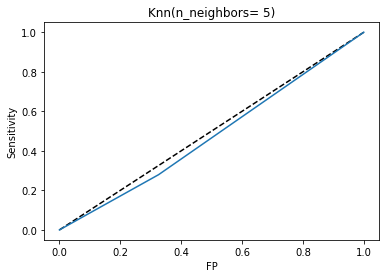

In [35]:
'''Receiver Operator Curve (ROC) and Area under the curve (AUC)'''
fpr, tpr, thresholds = roc_curve(y_valid, y_predict)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Knn')
plt.xlabel('FP')
plt.ylabel('Sensitivity')
plt.title('Knn(n_neighbors= 5)')
plt.show()

In [36]:
roc_auc_score(y_valid, y_predict)

0.47682709447415333

In [37]:
'''The accaury is not good at this time, we will reset the hyper-parameters to see if I can improve this model'''

'The accaury is not good at this time, we will reset the hyper-parameters to see if I can improve this model'

#### Step 4: GridSearchCV

In [38]:
params = {"n_neighbors": np.arange(1, 201),
          "weights":['uniform','distance'],
        "metric": ["euclidean", "cityblock","minkowski","manhattan","chebyshev"]}

knn_model_test = KNeighborsClassifier()
knn_cv_model = GridSearchCV(knn_model_test, params)
knn_cv_model_result = knn_cv_model.fit(X_train,y_train)
y_predict_knn_cn = knn_cv_model.predict(X_valid)

In [39]:
'''The highest accuary with the following hyper-parameters'''
print(knn_cv_model.best_params_)

{'metric': 'cityblock', 'n_neighbors': 51, 'weights': 'uniform'}


In [40]:
knn_cv_model.best_score_

0.6522222222222221

In [41]:
print("By testing with validation, we can see the model reach the highest accuary is "+ knn_cv_model.best_score_.astype(str)+
      " when n_neighbors is "+knn_cv_model.best_params_['n_neighbors'].astype(str)+", weights is "+ knn_cv_model.best_params_['weights']+
      ", and metric is "+knn_cv_model.best_params_['metric'])

By testing with validation, we can see the model reach the highest accuary is 0.6522222222222221 when n_neighbors is 51, weights is uniform, and metric is cityblock


In [42]:
"""Since we have the best  hyper-parameters, we are going to use those hyper-parameters and build my final model"""
knn_model_final = KNeighborsClassifier(n_neighbors = knn_cv_model.best_params_['n_neighbors'],
                                       weights = knn_cv_model.best_params_['weights'],
                                       metric = knn_cv_model.best_params_['metric'])

X_train = my_train_valid.drop(columns=['Survived'])
Y = my_train_valid['Survived']

knn_model_final.fit(X_train,Y)

KNeighborsClassifier(metric='cityblock', n_neighbors=51)

In [43]:
knn_model_name = 'knn_model_final.sav'
joblib.dump(knn_model_final,knn_model_name)

['knn_model_final.sav']

#### Step 5: Evaluating with test set

In [44]:
print(my_test.shape)
my_test.head(2)

(209, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1101,1,3,"Delalic, Mr. Redjo",male,25.0,0,0,349250,7.8958,NaN,S
1,1102,0,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.5250,NaN,S


In [45]:
my_test = my_test.drop(columns=['Cabin'])

In [46]:
print(my_test.shape)
my_test.head(2)

(209, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1101,1,3,"Delalic, Mr. Redjo",male,25.0,0,0,349250,7.8958,S
1,1102,0,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.5250,S


In [47]:
my_test = str_to_cat(my_test)

In [48]:
my_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  209 non-null    int64   
 1   Survived     209 non-null    int64   
 2   Pclass       209 non-null    int64   
 3   Name         209 non-null    category
 4   Sex          209 non-null    category
 5   Age          165 non-null    float64 
 6   SibSp        209 non-null    int64   
 7   Parch        209 non-null    int64   
 8   Ticket       209 non-null    category
 9   Fare         209 non-null    float64 
 10  Embarked     209 non-null    category
dtypes: category(4), float64(2), int64(5)
memory usage: 31.1 KB


In [49]:
print(my_test.Embarked.cat.categories)
print(my_test.Sex.cat.categories)

Index(['C', 'Q', 'S'], dtype='object')
Index(['female', 'male'], dtype='object')


In [50]:
my_test,my_test_table = mydf_preprocessor(my_test, null_table = my_table)

In [51]:
my_test_table

{'Age': 28.0, 'Fare': 14.4583}

In [52]:
print(my_test.shape)
my_test.head(3)

(209, 13)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
0,1101,1,3,47,2,25.0,0,0,106,7.8958,3,False,False
1,1102,0,3,6,2,32.0,0,0,146,22.5250,3,False,False
2,1103,1,3,62,2,28.0,0,0,187,7.0500,3,True,False


In [53]:
X_Con_test = my_test[['Age', 'Fare']]
X_Cat_test = my_test.drop(X_Con_test,axis = 1)
print(X_Cat_test.shape,X_Con_test.shape)
print(X_Cat_test.head(2))
print(X_Con_test.head(2))

(209, 11) (209, 2)
   PassengerId  Survived  Pclass  Name  Sex  SibSp  Parch  Ticket  Embarked  \
0         1101         1       3    47    2      0      0     106         3   
1         1102         0       3     6    2      0      0     146         3   

   Age_na  Fare_na  
0   False    False  
1   False    False  
    Age     Fare
0  25.0   7.8958
1  32.0  22.5250


In [54]:
X_con_sct = pd.DataFrame(scaler.transform(X_Con_test))
X_con_sct.columns = ["Age","Fare"]
print(X_con_sct.shape)
X_con_sct.head(2)

(209, 2)


,Age,Fare
0,-0.343408,-0.489547
1,0.196729,-0.203944


In [55]:
df_list_test = [X_Cat_test,X_con_sct]
my_test = pd.concat(df_list_test,axis = 1)
print(my_test.shape)
my_test.head(2)

(209, 13)


,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1101,1,3,47,2,0,0,106,3,False,False,-0.343408,-0.489547
1,1102,0,3,6,2,0,0,146,3,False,False,0.196729,-0.203944


In [56]:
X_my_test =my_test.drop(columns=['Survived'],axis=1)
y_my_test = my_test['Survived']
print(X_my_test.shape,y_my_test.shape)

(209, 12) (209,)


In [57]:
X_my_test.head(2)

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1101,3,47,2,0,0,106,3,False,False,-0.343408,-0.489547
1,1102,3,6,2,0,0,146,3,False,False,0.196729,-0.203944


In [58]:
y_my_test.head(2)

0    1
1    0
Name: Survived, dtype: int64

In [59]:
kNN_loaded = joblib.load('knn_model_final.sav')

In [60]:
y_test_pred = kNN_loaded.predict(X_my_test)

In [61]:
'''check the accuary on test data set'''
knn_test_score = classification_report(y_my_test, y_test_pred)
print(knn_test_score)

              precision    recall  f1-score   support

           0       0.55      0.92      0.69       118
           1       0.25      0.03      0.06        91

    accuracy                           0.54       209
   macro avg       0.40      0.48      0.38       209
weighted avg       0.42      0.54      0.42       209



In [62]:
print(accuracy_score(y_my_test, y_test_pred),
      matthews_corrcoef(y_my_test, y_test_pred),f1_score(y_my_test, y_test_pred))

0.5358851674641149 -0.09229273519660021 0.05825242718446602


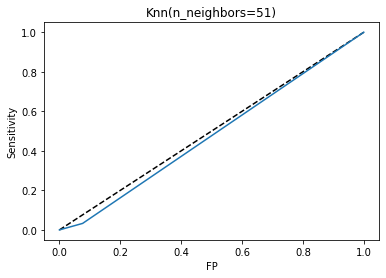

In [63]:
"""Receiver Operator Curve (ROC) and Area under the curve (AUC)"""
fpr, tpr, thresholds = roc_curve(y_my_test, y_test_pred)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Knn')
plt.xlabel('FP')
plt.ylabel('Sensitivity')
plt.title('Knn(n_neighbors=' + knn_cv_model.best_params_['n_neighbors'].astype(str)+')')
plt.show()

In [64]:
roc_auc_score(y_my_test, y_test_pred)

0.47834792326317754

### Question 2:

What do you think some of the disadvantages of k-NN algorithm are?

1. K-NN algorithm is sensitive to noisy data and missing values. From this assignment, we have to spend a lot of time to pre-process the data in order to let k-NN model to understand and have a better performance.
2. The settings of hyper-parameters. From this assignment, we can tell that different hyper-parameters are actually affecting a lot on accuary, which means that we have to try a lot in order to find the best fit hyper-parameters. For example, choosing the optimal number of neighbors to be consider while classifying the new data entry
3. K-NN model does not work well on imbalance data set.
4. We need to do feature scaling (standardization and normalization) before applying KNN algorithm to any dataset. If we don't do so, KNN may generate wrong prediction.
5. Accuracy depends on the quality of the data. And with large data, the prediction stage might be slow.
6. The KNN algorithm doesn't work well with high dimensional data because with large number of dimensions, it becomes difficult for the algorithm to calculate the distance in each dimension.


